In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [2]:
city = 'sj'
Xy = pd.read_pickle("Xy_"+city+".pkl")
#Xy = Xy.loc[1993:2003]
Xy.head(5)

features        vegetation                                        precipit_mm  \
measurements       ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw precipitation_amt_mm   
year weekofyear                                                                 
1990 18           0.122600  0.103725  0.198483  0.177617                12.42   
     19           0.169900  0.142175  0.162357  0.155486                22.82   
     20           0.032250  0.172967  0.157200  0.170843                34.54   
     21           0.128633  0.245067  0.227557  0.235886                15.36   
     22           0.196200  0.262200  0.251200  0.247340                 7.52   

features                   avg_temp_c                        \
measurements    reanalysis_air_temp_c reanalysis_avg_temp_c   
year weekofyear                                               
1990 18                     24.422857             24.592857   
     19                     25.061429             25.292857   
     20                     25.631429             25.728571   
     21                     25.837143             26.078571   
     22                     26.368571             26.514286   

features        reanalysis_dew_point_temp_c                max_temp_c  \
measurements    reanalysis_dew_point_temp_c reanalysis_max_air_temp_c   
year weekofyear                                                         
1990 18                           19.264286                     26.65   
     19                           20.801429                     27.75   
     20                           22.284286                     27.35   
     21                           22.160000                     28.25   
     22                           22.671429                     28.75   

features                       min_temp_c  ...  \
measurements    reanalysis_min_air_temp_c  ...   
year weekofyear                            ...   
1990 18                             22.75  ...   
     19                             23.25  ...   
     20                             24.15  ...   
     21                             23.85  ...   
     22                             24.35  ...   

features        reanalysis_relative_humidity_percent  \
measurements    reanalysis_relative_humidity_percent   
year weekofyear                                        
1990 18                                    73.365714   
     19                                    77.368571   
     20                                    82.052857   
     21                                    80.337143   
     22                                    80.460000   

features        reanalysis_specific_humidity_g_per_kg   diur_temp_rng_c  \
measurements    reanalysis_specific_humidity_g_per_kg reanalysis_tdtr_k   
year weekofyear                                                           
1990 18                                     14.012857          2.628571   
     19                                     15.372857          2.371429   
     20                                     16.848571          2.300000   
     21                                     16.672857          2.428571   
     22                                     17.210000          3.014286   

features                avg_temp_c         diur_temp_rng_c         max_temp_c  \
measurements    station_avg_temp_c station_diur_temp_rng_c station_max_temp_c   
year weekofyear                                                                 
1990 18                  25.442857                6.900000               29.4   
     19                  26.714286                6.371429               31.7   
     20                  26.714286                6.485714               32.2   
     21                  27.471429                6.771429               33.3   
     22                  28.942857                9.371429               35.0   

features                min_temp_c       precipit_mm labels week_number  
measurements    station_min_temp_c station_precip_mm                     
year weekofye

In [3]:
cases = 'labels'
rain = ('precipit_mm', 'precipitation_amt_mm')
hum = ('reanalysis_relative_humidity_percent', 'reanalysis_relative_humidity_percent')
temp = ('avg_temp_c', 'reanalysis_avg_temp_c')
dew_pt = ('reanalysis_dew_point_temp_c', 'reanalysis_dew_point_temp_c')
precipit_density = ('reanalysis_precip_amt_kg_per_m2', 'reanalysis_precip_amt_kg_per_m2')
veget_ne = ('vegetation', 'ndvi_ne')
veget_nw = ('vegetation', 'ndvi_nw')
max_temp = ('max_temp_c', 'reanalysis_max_air_temp_c')
min_temp = ('min_temp_c', 'reanalysis_min_air_temp_c')

### Simplification: binary output outbreak/no outbreak

Instead of predicting the exact number of cases per week, one can simplify the problem by trying to predict when the number of cases will exceed a fixed threshold, which we interpret as an outbreak. From the practical point of vue, this is still an important question, as one wants to warn the population of the risk of an imminent outbreak. 

In [4]:
# Define an outbreak as more than threshold #cases per week
threshold = 100
Xy['outbreak '+str(threshold)] = (Xy.loc[:,'labels'] > threshold)

### Incidence Lag

One important aspect when studying the impact of weather on dengue incidence is the **lag** effect: under the optimal weather conditions, it can take days for the mosquitoes to mature, and for the dengue virus to incubate. Thus there is a lag between the effect of weather and dengue incidence (Distributed Lag Modelling). 

#### New binary output variable

For any week, observe if an outbreak happened within the next $k$ weeks. 

In [5]:
def Lag(k):
    lag = pd.Series(index = Xy.index)
    for i in range(len(Xy)-k):
        lag.iloc[i] = np.any(Xy['outbreak '+str(threshold)].iloc[i: i+k])
    for i in range(k):
        lag.iloc[-1-i] = np.any(Xy['outbreak '+str(threshold)].iloc[-1-i:])
    return lag

### Probability of outbreak depending on climate features

(Empirical) Probability of outbreak within the next k weeks if feature > t

In [6]:
def ProbaLagFeature(t, lag, feature):
    out = np.count_nonzero(lag[(Xy[feature] > t)])
    tot = np.count_nonzero((Xy[feature] > t))
    return out/(tot+0.01) #avoid division by 0

In [7]:
def ProbaLagFeatures(vals, lag, features):
    zipped = zip(features, vals)
    concat = [(Xy[pair[0]] > pair[1]) for pair in zipped]
    mask = pd.concat(concat, axis = 1).all(axis = 1)
    out = np.count_nonzero(lag[mask])
    tot = np.count_nonzero(mask)
    return out/(tot+0.01)

In [8]:
def ProbaLagGraph(t_min, t_max, lag, k, feature):
    T = np.linspace(t_min, t_max)
    P = [ProbaLagFeature(t, lag, feature) for t in T]
    plt.rcParams['figure.figsize'] = [12, 5]
    plt.plot(T, P, label = 'Within '+ str(k) + ' weeks')
    plt.xlabel(feature[0])
    plt.ylabel('P(case > ' + str(threshold)+ ')' )
    plt.title('Probability of outbreak')
    plt.legend()

In [9]:
ks = range(3,9)
lags = [Lag(k) for k in ks]

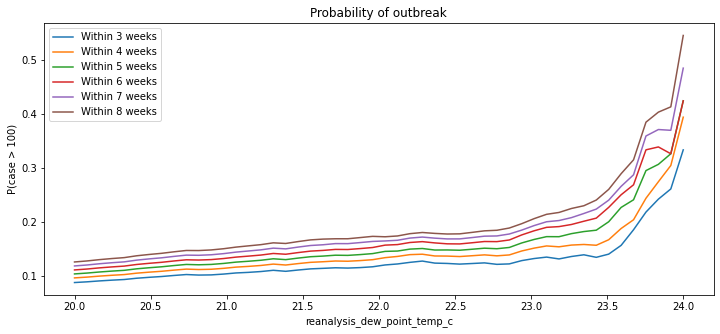

Dew point good predictor of dengue incidence. Proba significantly high when t > 23.5


In [10]:
for k in ks:
    ProbaLagGraph(20, 24, lags[k-3], k, dew_pt)
plt.show()
print('Dew point good predictor of dengue incidence. Proba significantly high when t > 23.5')

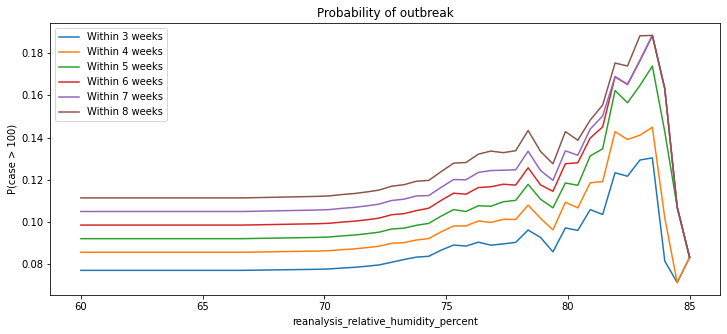

In [11]:
for k in ks:
    ProbaLagGraph(60, 85, lags[k-3], k, hum)
plt.show()

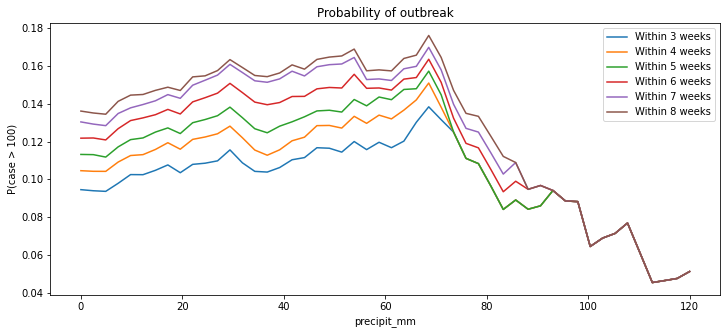

Too heavy rain destroys mosquitoes habitat


In [12]:
for k in ks:
    ProbaLagGraph(0, 120, lags[k-3], k, rain)
plt.show()
print('Too heavy rain destroys mosquitoes habitat')

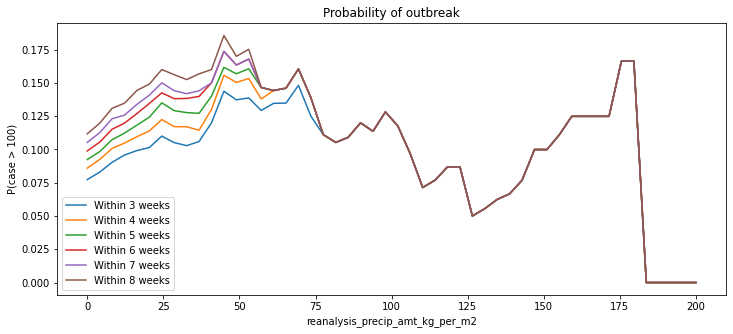

In [13]:
for k in ks:
    ProbaLagGraph(0, 200, lags[k-3], k, precipit_density)
plt.show()

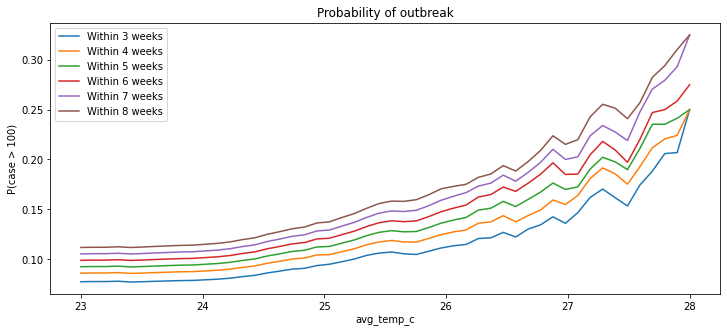

In [14]:
for k in ks:
    ProbaLagGraph(23, 28, lags[k-3], k, temp)
plt.show()

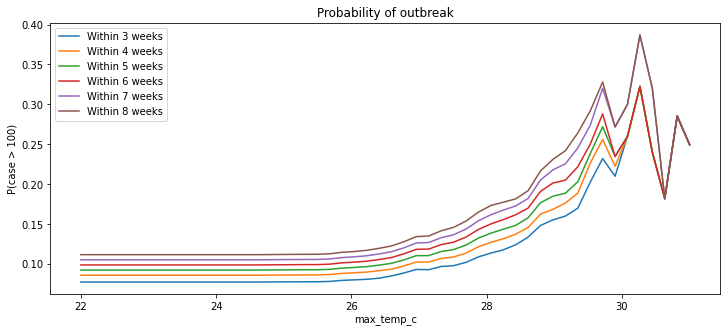

In [15]:
for k in ks:
    ProbaLagGraph(22, 31, lags[k-3], k, max_temp)
plt.show()

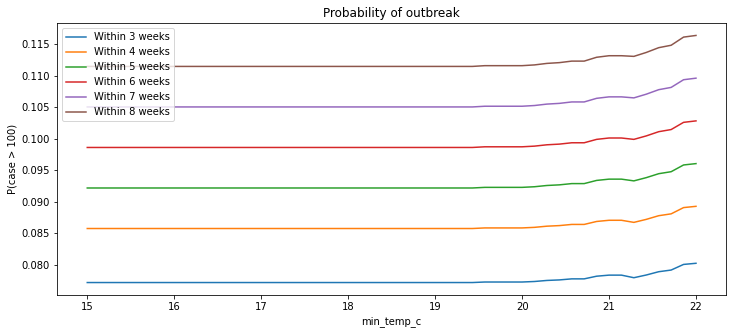

In [16]:
for k in ks:
    ProbaLagGraph(15, 22, lags[k-3], k, min_temp)
plt.show()

### Mixture models?

Linear relations:

dew point - humidity

dew point - temperature

In [17]:
k = 6
lag = Lag(k)

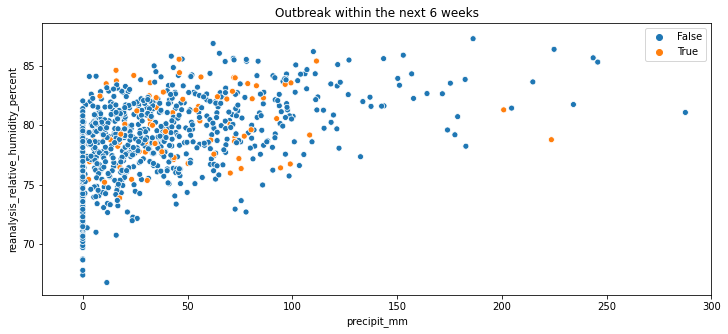

In [18]:
plt.rcParams['figure.figsize'] = [12, 5]
seaborn.scatterplot(x = Xy[rain], y = Xy[hum], hue = lag)
plt.xlabel(rain[0])
plt.ylabel(hum[0])
plt.xlim(xmax = 300)
plt.title('Outbreak within the next ' + str(k) + ' weeks')
plt.show()

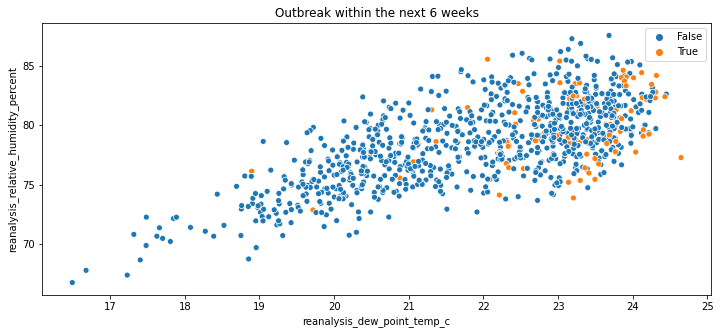

In [19]:
plt.rcParams['figure.figsize'] = [12, 5]
seaborn.scatterplot(Xy[dew_pt], Xy[hum], hue = lag)
plt.xlabel(dew_pt[0])
plt.ylabel(hum[0])
plt.title('Outbreak within the next ' + str(k) + ' weeks')
plt.show()

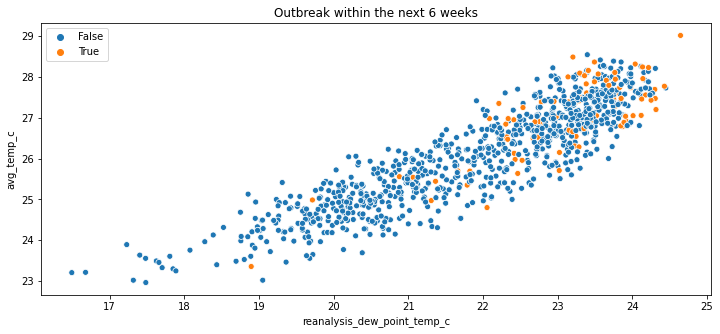

In [20]:
plt.rcParams['figure.figsize'] = [12, 5]
seaborn.scatterplot(Xy[dew_pt], Xy[temp], hue = lag)
plt.xlabel(dew_pt[0])
plt.ylabel(temp[0])
plt.title('Outbreak within the next ' + str(k) + ' weeks')
plt.show()

In [21]:
pi = np.count_nonzero(lag)/len(Xy)
pi

0.09860664523043944

In [22]:
mu1 = Xy[(lag)].mean(axis = 0)
mu0 = Xy[(lag == False)].mean(axis = 0)
sig2_1 = ((Xy[(lag)]-mu0)**2).mean(axis = 0)
sig2_0 = ((Xy[(lag==False)]-mu0)**2).mean(axis = 0) 

In [23]:
def phi0(x): 
    return 1/np.sqrt(2*np.pi*sig2_0[dew_pt])*np.exp(-(x - mu0[dew_pt])**2/(2*sig2_0[dew_pt]))
def phi1(x): 
    return 1/np.sqrt(2*np.pi*sig2_1[dew_pt])*np.exp(-(x - mu1[dew_pt])**2/(2*sig2_1[dew_pt]))
def f(x):
    return pi*phi1(x)/(pi*phi1(x) + (1-pi)*phi0(x))

In [24]:
sig2_1[dew_pt]

2.5397714970904057

In [25]:
f(23)

0.12418794754838629

In [26]:
from scipy.stats import norm
def F(x, feature):
    return pi*(1-norm.cdf((x - mu1[feature])/np.sqrt(sig2_1[feature])))/(pi*(1-norm.cdf((x - mu1[feature])/np.sqrt(sig2_1[feature])))+(1-pi)*(1-norm.cdf((x - mu0[feature])/np.sqrt(sig2_0[feature]))))

In [27]:
def MixtureGraph(t_min, t_max, feature):
    plt.rcParams['figure.figsize'] = [12, 5]
    x = np.linspace(t_min,t_max)
    plt.plot(x, F(x, feature), label = 'Gaussian mixture model')
    ProbaLagGraph(t_min, t_max, lag, k, feature)
    plt.show()    

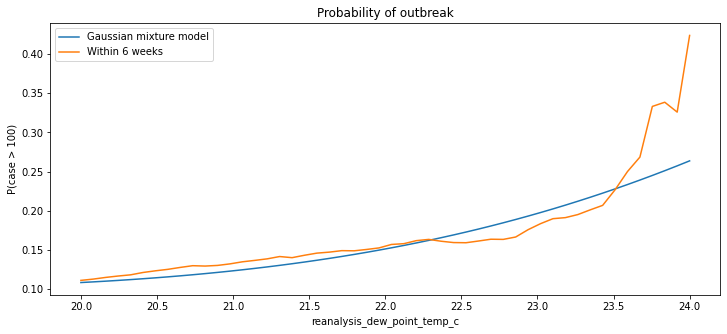

In [28]:
MixtureGraph(20, 24, dew_pt)

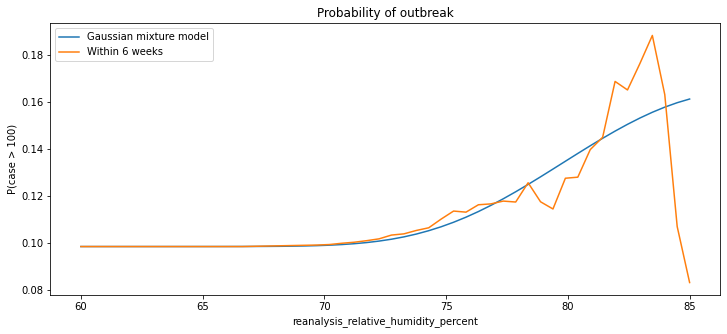

In [29]:
MixtureGraph(60, 85, hum)

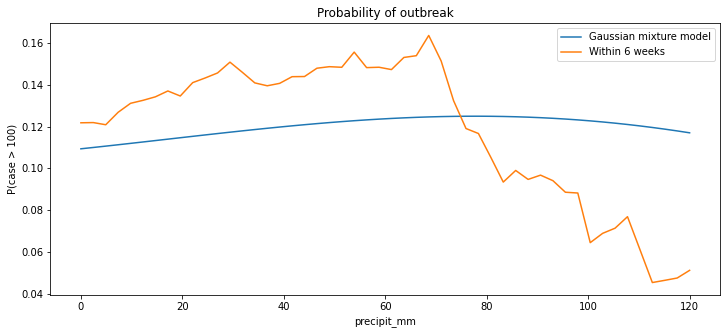

In [30]:
MixtureGraph(0, 120, rain)

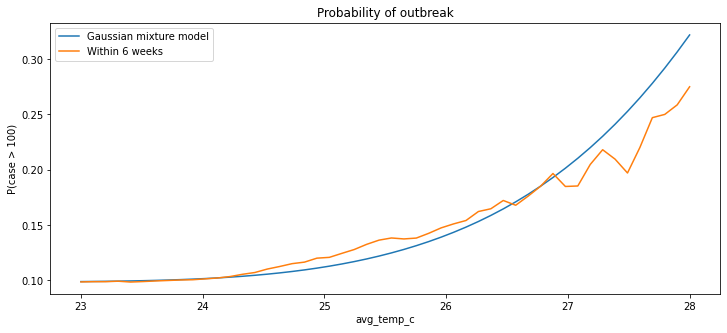

In [31]:
MixtureGraph(23, 28, temp)

### Tree  model

In [32]:
from sklearn import tree

In [33]:
X = Xy[[rain, hum, temp, dew_pt, precipit_density]]
Y = Xy[cases]

In [34]:
from sklearn.model_selection import train_test_split
X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, train_size=0.6,test_size=0.4)

In [35]:
clf = tree.DecisionTreeClassifier(ccp_alpha = 0.02)
clf = clf.fit(X_tr, Y_tr)

In [36]:
clf.score(X_te, Y_te)

0.024064171122994651

[Text(334.8, 135.9, 'gini = 0.981\nsamples = 559\nvalue = [3, 8, 12, 25, 10, 13, 25, 17, 12, 13, 13, 11\n13, 18, 17, 7, 14, 24, 14, 8, 10, 11, 7, 8, 7\n9, 12, 5, 8, 6, 11, 7, 3, 10, 6, 6, 3, 8, 3\n2, 5, 2, 2, 3, 2, 1, 4, 4, 3, 3, 3, 1, 3, 3\n2, 5, 7, 2, 1, 2, 1, 2, 1, 2, 3, 1, 2, 3, 3\n4, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1\n1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1\n3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1\n1, 1, 1, 1]')]

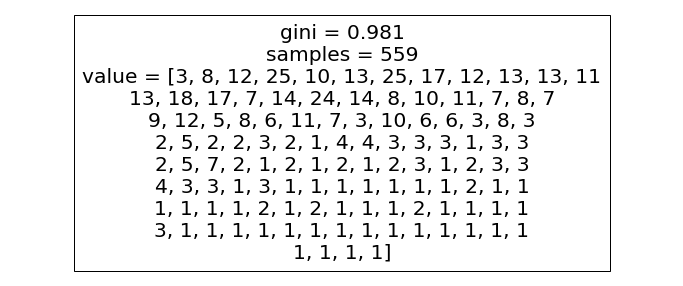

In [37]:
tree.plot_tree(clf) 

In [38]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("dengue_tree") 

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'dengue_tree'], make sure the Graphviz executables are on your systems' PATH

##### Spline regularization

In [14]:
#https://pypi.org/project/csaps/
from csaps import csaps

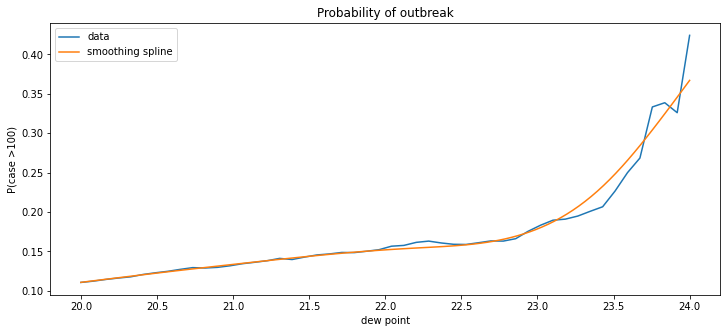

In [23]:
plt.rcParams['figure.figsize'] = [12, 5]
T = np.linspace(20, 24)
P = [ProbaLagFeature(t, lag, dew_pt) for t in T]
Ts = np.linspace(T[0], T[-1], 100)
Ps = csaps(T, P, Ts, smooth = 0.9)
plt.plot(T, P, label = 'data') 
plt.plot(Ts, Ps, '-', label = 'smoothing spline')
plt.xlabel('dew point')
plt.ylabel('P(case >100)')
plt.title('Probability of outbreak')
plt.legend()
plt.show()

In [ ]:
features = [dew_pt, temp, hum]
vals = [22, 27, 80]
ProbaLagFeatures(vals, lag, features)

In [ ]:
ProbaLagFeature(22, lag, dew_pt)

In [ ]:
ProbaLagFeature(27, lag, temp)

In [ ]:
ProbaLagFeature(55, lag, rain)

In [ ]:
features = [dew_pt, rain]
vals = [23.5, 55]
ProbaLagFeatures(vals, lag, features)

In [ ]:
features = [dew_pt, temp]
vals = [23.5, 28]
ProbaLagFeatures(vals, lag, features)

In [ ]:
features = [dew_pt, max_temp]
vals = [23.5, 29]
ProbaLagFeatures(vals, lag, features)

In [ ]:
features = [dew_pt, min_temp]
vals = [23.5, 25]
ProbaLagFeatures(vals, lag, features)

In [ ]:
foo = pd.concat([lag, dew_pt], axis = 1)

In [ ]:
foo

In [ ]:
from sklearn.model_selection import train_test_split
foo_train, foo_test = train_test_split(foo, train_size=0.55,test_size=0.45, shuffle = False)

In [ ]:
foo_train_lag = foo_train[0]
foo_test_lag = foo_test[0]

In [ ]:
foo_train_dew = foo_train[('reanalysis_dew_point_temp_c', 'reanalysis_dew_point_temp_c')]
foo_test_dew = foo_test[('reanalysis_dew_point_temp_c', 'reanalysis_dew_point_temp_c')]

In [ ]:
ProbaLagFeature(23.5, foo_train_lag, foo_train_dew)

In [ ]:
ProbaLagFeature(23.5, foo_test_lag, foo_test_dew)

In [ ]:
ProbaLagGraph(20, 24, foo_train_lag, 8, foo_train_dew, 'dew')
ProbaLagGraph(20, 24, foo_test_lag, 8, foo_test_dew, 'dew')

### Wavelet coherence analysis

In [ ]:
#https://pywavelets.readthedocs.io/en/latest/

### Features over years

In [ ]:
def FeatureOverYears(feature, ylabel):
    years = set(feature.index.get_level_values(0))
    plt.rcParams['figure.figsize'] = [12, 7]
    plt.xlabel('weeks of year')
    plt.ylabel(ylabel)
    for year in years:
        plt.scatter(feature.loc[year].index, feature.loc[(year,)])
        
    plt.legend([str(year) for year in years])
    plt.show()
    

In [ ]:
FeatureOverYears(cases, 'cases')

In [ ]:
FeatureOverYears(dew_pt, 'dew point')

In [ ]:
FeatureOverYears(hum, 'humidity')

In [ ]:
FeatureOverYears(precipit_density, 'precipit_density')

In [ ]:
FeatureOverYears(rain, 'rain')